#Init library

In [1]:
!pip install dgl

In [2]:
import dgl
import numpy as np
import pandas as pd


Using backend: pytorch


In [3]:
!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py

#Load data

In [0]:
df3=pd.read_csv("https://raw.githubusercontent.com/covidsimteam/Contact-Tracing/master/dgl_map/estadoslatlon.csv")
df2=pd.read_csv('https://raw.githubusercontent.com/covidsimteam/Contact-Tracing/master/dgl_map/DensPob.csv')
estados_list=df3["Estado"].to_list()
lat_list=df3["Lat"]
lon_list=df3['Long']


##Visualise Data

In [5]:
densidad=df2.sort_values(by=['Densidad'])
fig = px.bar(densidad, y="Estado", x="Densidad", orientation='h',height=800,width=800,labels={'Densidad':'Population Density [inhabitants per square km]','Estado':'State'})
fig.show()

#Prepare DGLGraph Graph

In [0]:
n_nodes =32

G=dgl.DGLGraph()

In [0]:
G.add_nodes(32)

In [0]:
import numpy as np
def build_map():
  src=np.array([0 ,0 ,0,
                1 ,1 ,
                2 ,
                3 ,3 ,3 ,
                4 ,4 ,4 ,
                5 ,5 ,5 ,
                6 ,6 ,6 ,6 ,
                7 ,7 ,7 ,7 ,7 ,7 , 
                8 ,8 , 
                9 ,9 ,9 ,9 ,9 ,9 , 
                10 ,10 ,10 ,10 ,10 ,
                11 ,11 ,11 ,11 ,11 ,
                12 ,12 ,12 ,12 ,12 ,12 ,
                13 ,13 ,13 ,13 ,13 ,13 ,
                14  ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,14 ,
                15 , 15 ,15 ,15 ,15 ,15 ,
                16 ,16 ,16 ,16 ,
                17 ,17 ,17 , 
                18 ,18 ,18 ,
                19 ,19 ,19 ,19 ,
                20 ,20 ,20 ,20 ,20 ,20 ,20 , 
                21 ,21 ,21 ,21 ,21 ,
                22 ,22 ,
                23 ,23 ,23 ,23 ,23 ,23 ,
                24 ,24 ,24 ,24 ,
                25 ,25 ,25 ,
                26 ,26 ,26 ,
                27 ,27 ,27 ,
                28 ,28 ,28 ,
                29 ,29 ,29 ,29 ,29 ,29 ,
                30 ,30,
                31 ,31 ,31 ,31 ,31])
  dst=np.array([ 17, 31,5,
       8, 25,
       1,
       22, 26, 30,
       14, 16, 20,
       19, 26, 29,
       7, 9, 24, 25,
       6, 9, 31, 23, 18, 27,
       13, 15, 
       6, 7, 13, 17, 24, 31, 
       23, 31, 13, 15, 21,
       15, 14, 16, 20, 19, 
       29, 23, 21, 14, 28, 20,
       17, 31, 0, 10, 15, 8,
       21 , 10, 15, 11, 16, 4, 20, 28, 12,
       13,  8, 11, 14, 21, 10,
       11, 20, 4, 14,
       24, 9, 13, 
       7, 23, 27,
       11, 5, 29, 20,
       11, 19, 29, 12, 28, 14, 16, 
       23, 10, 15, 14, 12,
       3, 30,
       29, 27, 18, 31, 10, 21,
       25, 6, 9, 17,
       1, 6, 24,
       29, 5, 3,
       18, 23, 29,
       20, 14, 12,
       27, 23, 12, 20, 19, 26,
       3, 22,
       7, 9, 13, 0, 23])
  # u=np.concatenate([src])
  # v=np.concatenate([dst,src])
  return dgl.DGLGraph((src,dst))

In [0]:
G=build_map()

In [41]:
print(G.number_of_nodes())
print(G.number_of_edges())

32
133


## Convert To Networkx Graph For Viz

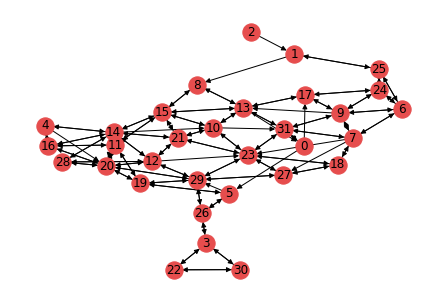

In [42]:
import networkx as nx
nx_G = G.to_networkx().to_directed()
pos = nx.kamada_kawai_layout(nx_G)

nx.draw(nx_G, pos, with_labels=True, node_color=[[.9, .3, .3]])

##Adding Features

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

embed = nn.Embedding(n_nodes, n_nodes)  

In [0]:
x = torch.arange(0,n_nodes)
G.ndata['feat'] =torch.nn.functional.one_hot(x)
G.ndata['featm'] =torch.nn.functional.one_hot(x)

In [45]:
for i in range(n_nodes):
  G.ndata['feat'][i]=G.ndata['feat'][i]*df2['Densidad'][i]
  G.ndata['featm'][i]=G.ndata['feat'][i]*df2['Densidad'][i]*2

print(G.ndata['feat'][31])

tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 607])


#GraphConvolution

In [0]:
from dgl.nn.pytorch import GraphConv

In [0]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h


In [0]:
nodes_infected =[3, 5]
infection_severity = [4,0]

inputs = embed.weight
labeled_nodes = torch.tensor(nodes_infected)   #node number
labels = torch.tensor(infection_severity)    #infectionLevel

max_severity = max(infection_severity)

In [62]:
import itertools

epoch_ = 50
hiddenLayer_1 =100

net = GCN(n_nodes, hiddenLayer_1, max_severity+1)



optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(epoch_):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 1.9382
Epoch 1 | Loss: 1.1012
Epoch 2 | Loss: 0.5955
Epoch 3 | Loss: 0.3186
Epoch 4 | Loss: 0.1699
Epoch 5 | Loss: 0.0890
Epoch 6 | Loss: 0.0458
Epoch 7 | Loss: 0.0240
Epoch 8 | Loss: 0.0129
Epoch 9 | Loss: 0.0073
Epoch 10 | Loss: 0.0042
Epoch 11 | Loss: 0.0026
Epoch 12 | Loss: 0.0016
Epoch 13 | Loss: 0.0010
Epoch 14 | Loss: 0.0007
Epoch 15 | Loss: 0.0005
Epoch 16 | Loss: 0.0003
Epoch 17 | Loss: 0.0002
Epoch 18 | Loss: 0.0002
Epoch 19 | Loss: 0.0001
Epoch 20 | Loss: 0.0001
Epoch 21 | Loss: 0.0001
Epoch 22 | Loss: 0.0001
Epoch 23 | Loss: 0.0001
Epoch 24 | Loss: 0.0000
Epoch 25 | Loss: 0.0000
Epoch 26 | Loss: 0.0000
Epoch 27 | Loss: 0.0000
Epoch 28 | Loss: 0.0000
Epoch 29 | Loss: 0.0000
Epoch 30 | Loss: 0.0000
Epoch 31 | Loss: 0.0000
Epoch 32 | Loss: 0.0000
Epoch 33 | Loss: 0.0000
Epoch 34 | Loss: 0.0000
Epoch 35 | Loss: 0.0000
Epoch 36 | Loss: 0.0000
Epoch 37 | Loss: 0.0000
Epoch 38 | Loss: 0.0000
Epoch 39 | Loss: 0.0000
Epoch 40 | Loss: 0.0000
Epoch 41 | Loss: 0.0000
Ep

In [0]:
import pandas as pd
df=pd.DataFrame(all_logits[epoch_-1][:].numpy())

In [0]:
lista=[]
for i in range(32):
  lista.append((all_logits[epoch_-1][i].numpy().argmax()))

df['li']=pd.Series(lista)

#PCA with the output and Visualization

In [84]:
import matplotlib.animation as animation
from matplotlib import rc

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pcaall_logits = PCA(n_components=2)

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

def draw(i):
    cls1color =['violet', 'green','brown', 'yellow', 'red' ]
    pos = {}
    colors = []
    all_logitstemp = pcaall_logits.fit_transform(all_logits[i])
    for v in range(n_nodes):
        pos[v] = all_logitstemp[v]
        cls = all_logits[i][v].argmax()
        colors.append(cls1color[cls])
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(G.to_networkx().to_directed(), pos, node_color=colors,
            with_labels=True, node_size=200, ax=ax)

fig, ax = plt.subplots()
plt.close()
# fig.clf()
# ax = fig.subplots()
# draw(2)  # draw the prediction of the first epoch

ani = animation.FuncAnimation(fig, draw, frames=10, interval=500)
rc('animation', html='jshtml')
# # ani.save('animation.mp4', writer=writer)
ani

#GeoMap

In [0]:
df['Lat']=lat_list
df['Long']=lon_list
df['Location']=estados_list

In [23]:
df

,0,1,2,3,4,li,Lat,Long,Location
0,2.378926,-1.750216,-1.669712,-1.958950,0.258187,0,26.930560,88.093590,ILAM_MECHI
1,3.033102,-1.223044,-2.038472,-2.144604,-1.532608,0,27.701671,83.465913,RUPANDEHI_LUMBINI
2,-0.260256,-1.610745,-2.731483,-2.523769,3.454145,4,27.753100,85.327400,KATHMANDU_BAGMATI
3,1.624555,-8.213421,-8.965841,-10.507283,14.181053,4,28.754510,81.605620,DAILEKH_BHERI
4,4.952198,-2.676615,-2.894136,-2.836831,-1.391966,0,27.807100,82.625320,DANG_RAPTI
5,10.185245,-6.245718,-6.677799,-7.376482,-0.415016,0,27.698710,83.314770,RUPANDEHI_LUMBINI
6,3.180491,-2.185425,-2.683046,-2.962302,-0.224359,0,27.822770,85.542270,SINDHUPALCHOK_BAGMATI
7,2.781289,-1.865492,-2.026150,-2.177685,0.313558,0,26.830283,87.287533,SUNSARI_KOSHI
8,1.566456,-1.487482,-1.375620,-1.610166,0.483480,0,27.687305,84.263723,NAWALPARASI_LUMBINI
9,3.535580,-2.842485,-3.010072,-3.572595,0.973607,0,26.596200,87.273580,SUNSARI_KOSHI


In [24]:
fig = px.scatter_geo(df, lat="Lat",lon="Long", color='li',size=df['li']+1,
                     #animation_frame="Fecha",
                     scope='asia',#range_color=[0,max(todos['conteo'])],
                     center={'lat':28.7,'lon':85.3},width=1200, height=1200,text = df['Location'],
                     projection="natural earth")


fig.show()